## Optimization and quantum simulation of a model for partial and complete qubit state estimation

This Jupyter notebook has a brief but also complete application of the method proposed by Saavedra and Romero [Saavedra](https://doi.org/10.1103/PhysRevA.99.042130) for doing complete qubit state tomography.

First we are setting up the problem. Here we want to estimate the three components of the Bloch vector that describes the initial state of a qubit $S$ without measuring the qubit itself. This can be done by using two auxiliary qubits, which we are going to call meters $A$ and $B$. These two meters interact with the qubit of interest in a way that, when we measure them, we can estimate the three components of the Bloch vector that describes the initial state of the qubit $S$.

For practical purposes of this notebook, the interaction between the qubits $S$, $A$ and $B$ is not going to be developed in detail. The main result is that the interaction can be written in terms of a Hamiltonian

$$H  = \left(\lambda_A\Pi^S_1 \otimes \Pi^A_1 \otimes I^B + \lambda_B \Pi^S_{+} \otimes I^A \otimes \Pi^B_1 \right),$$

where $\Pi_k^M = |k^M\rangle\langle k^M|$, with $k=1,+$ and $M=A,B$; $I_A$ and $I_B$ are identity operators associated to the Hilbert spaces of meters $A$ and $B$, respectively; and $\lambda_A$, $\lambda_B$ are constants. 
Here, $|{+}\rangle$ and $|{-}\rangle$ are the eigenstates of $\sigma_x.$
The corresponding time evolution operator, at time $T$, 

$$	U(\theta_A,\theta_B) = e^{-iHT/\hbar} =  \exp\left[-\frac{i}{\hbar}\int_{0}^{T} H(t) dt\right]=\exp\left(-i\theta_A\Pi^S_0 \otimes \Pi^A_0 \otimes I^B - i\theta_B \Pi^S_{+} \otimes I^A \otimes \Pi^B_0\right)$$

depends on the parameters $\theta_A =(\lambda_A T/\hbar)$ and $\theta_B = (\lambda_B T/\hbar)$.
With this in mind. We have enough tools for starting the implementation of this model in a quantum computer in order to see its performance in real quantum devices.

We first start by importing some libraries that we are going to use for the development of this project.


In [119]:
## Imports can be seen in the imports.ipynb file
%run imports.ipynb
IBMQ.load_account()
pi = np.pi
j = complex(0,1)

ibmqfactory.load_account:WARNING:2022-03-15 16:46:19,970: Credentials are already in use. The existing account in the session will be replaced.


### Qubits initialization

For this simulation, first, we have to initialize the qubits that we are going to use. In this case the $A$ and $B$ meters have to be initialized in the state $|+\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$. On the other hand, the qubit $S$ is initialized in an arbitrary state $|\psi^S\rangle = c_0|0\rangle + c_1 |1\rangle$. This state can be parametrized in terms of the angles of a $U$ gate,
$$U_{gate}(\theta,\phi,\lambda) = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i\phi}\cos(\theta/2) 
\end{pmatrix} .$$
So we define the initialization function.

In [120]:
def Initialization(angles = [0,0,0]):
    
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    #Initialice qubits
    qc.h(qr[0])                                    #A meter
    qc.h(qr[2])                                    #B meter
    qc.u(angles[0],angles[1],angles[2],[qr[1]])    #System
    
    Init_gate = qc.to_gate()
    Init_gate.name= "Initialization"
    
    return Init_gate

### Evolution operator

Now we have to implement the evolution operator. Since we are using qiskit for this simulation. We are going to use the qiskit `HamiltonianGate` class for defining a set of quantum gates that represent the time evolution operator.

In [121]:
def U_operator(th_A,th_B):

    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)
    
    #####==================================#####
    #####=========== Hamiltonian ==========#####
    #####==================================#####
    
    ## H is A x S x B
    
    HA=np.matrix([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,th_A,0],[0,0,0,0,0,0,0,th_A]])
    HB=np.matrix([[0,0,0,0,0,0,0,0],[0,th_B,0,th_B,0,0,0,0],[0,0,0,0,0,0,0,0],[0,th_B,0,th_B,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,th_B,0,th_B],[0,0,0,0,0,0,0,0],[0,0,0,0,0,th_B,0,th_B]])

    H=HA+HB
    
    ## We take T = 1 so then the interaction parameters are actually the angles \theta_{A} and \theta_{B}
    U=Operator(qiskit.extensions.HamiltonianGate(H, 1))
    
    qc.append(U,[0,1,2])
    
    U_gate=qc.to_gate()
    U_gate.name="U Operator"

    return U_gate    

### Qubit state estimation
Now we have to do the estimation of the Bloch vector that describes the initial state of the qubit $S$. For this we are going to introduce the theoretical model briefly. First we have to change the basis where we are going to measure the meters $A$ and $B$.
After measuring we will find a set of counts of the four possible states, whose probabilities are going to be saved in a vector $\textbf{P} = (p_{00},p_{01},p_{10},p_{11})^T$. Then, whith this results, we now have to decompose the evolution operator in order to build the measurement matrix which will allows us to do the state estimation. We can use the completeness relation to decompose the evolution operator acting over the three qubits by 
$$\begin{aligned} |\Psi(T)\rangle &= U |\psi_0^S\rangle\otimes |+^A\rangle \otimes |+^B\rangle \\
&= \frac{1}{2}\sum_{ij=0,1}U_{ij} |\psi_0^S\rangle |i^A j^B\rangle .\end{aligned}$$

Here $i$ and $j$ are related to the results obtained for the measurement of the meter $A$ and $B$ respectively.
Now we have to define three operators that we called $A$, $B$, and $C$. This operators will be important for the definition of the measurement matrix. they have the form

$$A = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-ij}$$
$$B = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{i -j}$$
$$C = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-i-j}$$

The minus sign indicates a negation of the result, so, if $i = 0$ then $ -i = 1$.

With this we can define some auxiliary vectors 
$$a_\mu = \frac{1}{2}Tr[A\sigma_\mu],$$
$$b_\mu = \frac{1}{2}Tr[B\sigma_\mu],$$
$$c_\mu = \frac{1}{2}Tr[C\sigma_\mu].$$
Where $\sigma_\mu = (1,\sigma_x,\sigma_y,\sigma_z).$ This vectors will be important for the definition of the measurement matrix which will be important later.

The probability $p_{kl}$ that meters A and B are detected in states $|k^A\rangle$ and $|{l^A}\rangle$, respectively, $k,l=\pm = \{0,1\},$ here $0$ represents the $-$ state and 1 represents the $+$ state, is
$$p_{kl} =  \frac{1}{4}s_0+\sum_{\mu = 1}^{3}\left(a_\mu k + b_\mu l + c_\mu kl\right) s_\mu.$$

This relation can be written in the form $\textbf{P}^T = \mathbb{T}\textbf{S}$. With $\textbf{S} = (s_0,s_x,s_y,s_z)$, here $s_x, s_y, s_z$ are the components of the Bloch vector that represents the initial state od the qubit $S$.

Inverting this relation we can estimate the initial state of the qubit $S$ by

$$\textbf{S} = \mathbb{T}^{-1}\textbf{P}. $$

The matrix $\mathbb{T}$ is an implicity defined matriz from the relation mentioned before. If the determinant of this matrix is different from $0$, then we can do the state tomography. So we have to be sure that this condition is satisfied befor doing the estimation. Now we are going to define this matrix and do the qubit state estimation.



In [122]:
def U_matrix(th_A,th_B):
    ## Definimos los qubits sobre los que actúa la compuerta
    A = QuantumRegister(1,'a')
    S = QuantumRegister(1,'s')
    B = QuantumRegister(1,'b')
    cr = ClassicalRegister(3)

    ## Ejecutamos la compuerta sobre estos regitros
    qc = QuantumCircuit(A,S,B, cr)
    qc.append(U_operator(th_A,th_B),[A,S,B])

    ## Usamos el simulador de IBM para obtener la matriz asociada al operador
    backend = BasicAer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    U = job.result().get_unitary(qc)
    return U

def T_matrix(U):
    
    ## we define the U_{ij} operators
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## and theyr adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
        
    ## The auxiliary operators A and B
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## We define the Pauli matrices and the identiry
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-complex(0,1)],[complex(0,1),0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## We evaluate the components of the a_\mu, b_\mu and c_\mu vectors
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))
    
    T = np.matrix([[0.25+a0+b0+c0, a1+b1+c1, a2+b2+c2, a3+b3+c3],[0.25+a0-b0-c0, a1-b1-c1, a2-b2-c2, a3-b3-c3],[0.25-a0+b0-c0, -a1+b1-c1, -a2+b2-c2, -a3+b3-c3],[0.25-a0-b0+c0, -a1-b1+c1, -a2-b2+c2, -a3-b3+c3]])
    return T


Now, given a set of parameters $\theta_A$ and $\theta_B$ we can evaluate if it is possible or note to do the qubit state tomography.

In [123]:
## Definition of the evolution operator parameters
th_A, th_B = np.random.uniform(-2*pi,2*pi),np.random.uniform(-2*pi,2*pi) 
U = U_matrix(th_A,th_B)
T = T_matrix(U)
T_det = np.abs(np.linalg.det(T))
if (T_det == 0):
    print('It is not possible to do complete qubit state tomography')
else:
    print('It is possible to do qubit state tomography!')

It is possible to do qubit state tomography!


## Implementation of the model and performance in a quantum computer

We have already set up all the necessary tools for implementing this model in a quantum circuit using qiskit and even test its performance in a real quantum device. We first define the circuit of this problem.


In [124]:
## Initial angles of the rotation that defines the initial state of the qubit S
angle_i=[pi/2,0,0]

## Quantum registers of the A, B and S qubits
A = QuantumRegister(1,'a')
S = QuantumRegister(1,'s')
B = QuantumRegister(1,'b')
cr = ClassicalRegister(3)

## Circuit initialization
tomography_circuit = QuantumCircuit(A,S,B, cr)

## We initialize our qubits
tomography_circuit.append(Initialization(angle_i),[A,S,B])
tomography_circuit.barrier()

## Apply the evolution operator
tomography_circuit.append(U_operator(th_A,th_B),[A,S,B])
tomography_circuit.barrier()

## Change the measurement basis
tomography_circuit.h(A)                     #A
tomography_circuit.h(B)                     #B
tomography_circuit.barrier()

## Measurement of the A and B meters
tomography_circuit.measure(A,cr[0])         #A
tomography_circuit.measure(B,cr[2])         #B
 

base_tomography_circuit = transpile(tomography_circuit,basis_gates=['rz','cx','id','sx','x','h','u','cp'],optimization_level=0) #gates CX, ID, RZ, SX, X
transpile_tomography_circuit = transpile(tomography_circuit,basis_gates=['cx','id','rz','sx','x'],optimization_level=3)
circuit = base_tomography_circuit.draw(output='mpl')
tomography_circuit.draw(output='latex').save('tomography_circuit.png')

The circuit used for the quantum state tomography can visualized as follows
<img src="tomography_circuit.png" width = 600px>

As you can see each part is divided by a barrier, the four parts of the circuit are essentially
1. Qubits initialization.
2. Application of the evolution operator.
3. Change of the measurement basis of the qubits $A$ and $B$.
4. Measurement of the meters.

Now we execute the circuit in a local simulator to see if the model works for doing qubit state tomography.

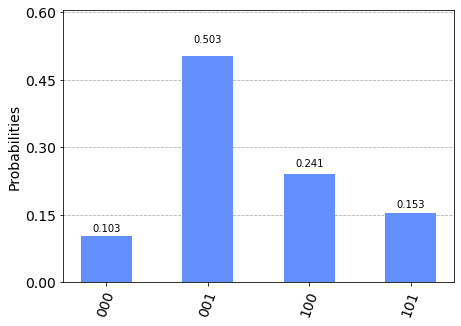

In [125]:
## Simulation of the circuit
simulator = Aer.get_backend('qasm_simulator')

shots = 1024

Sim_result_tomography_circuit=execute(tomography_circuit, backend=simulator,shots=shots).result()

Sim_result_counts_tomography_circuit=Sim_result_tomography_circuit.get_counts(tomography_circuit)

plt = plot_histogram(Sim_result_counts_tomography_circuit)
plt.savefig('test_circuit.png',dpi=1200)
plt

In [128]:
## We build the vector P
p00_test = Sim_result_counts_tomography_circuit['000']/shots
p01_test = Sim_result_counts_tomography_circuit['001']/shots
p10_test = Sim_result_counts_tomography_circuit['100']/shots
p11_test = Sim_result_counts_tomography_circuit['101']/shots

p_test = [p00_test,p01_test,p10_test,p11_test]

U = U_matrix(th_A, th_B)
T = T_matrix(U)
s = np.array(np.matmul(np.linalg.inv(T),p_test))

s1=s[0,1].real
s2=s[0,2].real
s3=s[0,3].real

s_test = [s1,s2,s3]


For comparing the estimation with the initial state of the qubit $S$ we will calculate the fidelity between this quantum states and we are going to graph them in the bloch sphere. The fidelity will be defined as $\mathcal{F} (\rho_0^S,\rho_e^S) = Tr[\sqrt{\sqrt{\rho_0^S} \rho_e^S \sqrt{\rho_0^S}}]^2$, if the states are pure it can be reduced to $\mathcal{F}(\rho_0^S,\rho_e^S) = |\langle{\psi_0^S|\psi_e^S}\rangle|^2.$
First we have to transform the bloch vector into a qubit state of the form $|\psi\rangle = c_0|0\rangle + c_1 |1\rangle. $

In [129]:
def bloch_vector_to_state(s):
    ## We transform the bloch vector into a qubit state
    s1 = s[0]
    s2 = s[1]
    s3 = s[2]
    
    if (s3>0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3)
    elif (s3 == 0):
        th = pi/2
    elif (s3 < 0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3) + pi

    if (s1>0 and s2>0):
        phi = np.arctan(s2/s1)
    elif (s1>0 and s2<0):
        phi = np.arctan(s2/s1) + 2*pi
    elif (s1 == 0):
        phi = pi/2*np.sign(s2)
    elif (s1<0):
        phi = np.arctan(s2/s1) + pi

    ## We write the alpha and beta amplitudes
    c_0 = np.cos(th/2)
    c_1 = (np.cos(phi) + complex(0,1)*np.sin(phi))*np.sin(th/2)
    
    state = np.array([c_0,c_1])
    return state

def init_ang_to_bloch_vector(angles):
    
    th, phi, lam = angles
    
    s = np.array([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    
    return s

s_ideal = init_ang_to_bloch_vector(angle_i)
s_ideal

array([1.000000e+00, 0.000000e+00, 6.123234e-17])

Now we find the $c_0$ and $c_1$ component of the initial state of the qubit $S$ from its initialization

In [131]:
## Initialize a 1 qubit circuit
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

qc_i = QuantumCircuit(qr,cr)

## Use the U rotation that we used for initializing the qubit S
qc_i.u(angle_i[0],angle_i[1],angle_i[2],qr[0])

backend = BasicAer.get_backend('statevector_simulator') 
result = execute(qc_i, backend).result()

## Take the statevector
initial_state  = result.get_statevector(qc_i)
estim_state = bloch_vector_to_state(s_test)

print(initial_state,estim_state)
## Calculate the fidelity
fidelity = quantum_info.state_fidelity(initial_state,estim_state)

print('The fidelity betwee the initial state and its estimation is: ',fidelity)

## Save the plots for visualzation
plot_bloch_vector(s_test, title="Estimated state").savefig("estimation_test.png")
plot_bloch_vector(s_ideal, title="Initial state").savefig("initial_test.png")

[0.70710678+0.j 0.70710678+0.j] [0.71395268+0.j         0.69937074-0.03394325j]
The fidelity betwee the initial state and its estimation is:  0.9993176113978102


We now print the bloch spheres of these states
<table>
     <tr>
        <th style="text-align:center" >
            Initial state
        </th>
        <th style="text-align:center">
            Estimation
        </th>
     </tr> 
     <tr>
         <td><img width=350px src='initial_test.png'></td>
         <td><img width=350px src='estimation_test.png'></td>
    </tr>
</table>

As you can see, the estimation model works pretty good even for random values of the parameters $\theta_A$ and $\theta_B$. However, we are interested in finding the best set of parameters for the estimation. Then, we are going to introduce the Fisher error parameter which will be the criteria for finding the best set up for doing qubit state estimation.

## Fisher error
The Fisher information matrix can be defined in different ways. for the purposes of this model we define its components as 
$$F_{\mu\nu}(\mathbf{s}) =  \sum_{j=0}^{3}\frac{1}{p_j} \frac{\partial p_j}{\partial s_\mu} \frac{\partial p_j}{\partial s_\nu}.$$
The Fisher information matrix for this model can be written as
$$\mathbb{F} = \mathbb{D}^T\left(\mathbb{V}\mathbb{P}^{-1}\mathbb{V}^T\right)\mathbb{D},$$

this depends on the measurement matrix $\mathbb{D}$, and the auxiliary matrices $\mathbb{V}$ and  $\mathbb{P}$
$$
		\mathbb{D} = \begin{pmatrix}
			a_1&b_1&c_1\\
			a_2&b_2&c_2\\
			a_3&b_3&c_3
		\end{pmatrix}, \quad
		\mathbb{V} = \begin{pmatrix}
			1 & 1 & -1 & -1\\
			1 & -1 & 1 & -1\\
			1 & -1 & -1 & 1
		\end{pmatrix}, \quad 
		\mathbb{P} =  \begin{pmatrix}
			p_{00} & 0 & 0 & 0 \\
			0 & p_{01} & 0 & 0 \\
			0 & 0 & p_{10} & 0 \\
			0 & 0 & 0 & p_{11}
		\end{pmatrix}.
$$

To study the dependence of the error on the initial state of qubit $S$, we write $c_0= e^{i\alpha_2}\cos\alpha_1$ and $c_1  = e^{- i\alpha_2}\sin\alpha_1$, where $\alpha_1\in [0,\pi/2],$ and $\alpha_2\in [0,\pi]$.

We define the error measure as the trace of the inverse of the Fisher information matrix
$$\Delta (\alpha_1,\alpha_2,\theta_A,\theta_B)=  \operatorname{Tr}(\mathbb{F}^{-1}).$$

Now that we have parametrized the error of this model, we calculate the mean error over all the possible states, this is 
$$\frac{1}{V}\int^{\frac{\pi}{2}}_{0}\int^{\pi}_0 \Delta (\alpha_1,\alpha_2,\theta_A,\theta_B)\sin2\alpha_1d\alpha_1 d\alpha_2.$$

Here the integration Volume is $V = \pi$. Now that we have the mean error in terms of the angles $\theta_A$ and $\theta_B$, we can optimize this in order to find the best set of parameters that minimize the mean error of the estimation model.
To do so we define the objective function to ve optimized.

In [134]:
## We have to parametrized the tomography to find p_ij
def tomography_parametrized(alpha_params, U):
    
    
    c_0 = np.exp(( alpha_params[1])*j)*np.cos(alpha_params[0])
    c_1 =  np.exp((-alpha_params[1])*j)*np.sin(alpha_params[0])
    initial_state = c_0, c_1

    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    ## We define the Kraus operators
    E_00 = (U_00 + U_01 + U_10 + U_11)/4
    E_01 = (U_00 - U_01 + U_10 - U_11)/4
    E_10 = (U_00 + U_01 - U_10 - U_11)/4
    E_11 = (U_00 - U_01 - U_10 + U_11)/4

    ## And their adjoints
    E_00d = (U_00d + U_01d + U_10d + U_11d)/4
    E_01d = (U_00d - U_01d + U_10d - U_11d)/4
    E_10d = (U_00d + U_01d - U_10d - U_11d)/4
    E_11d = (U_00d - U_01d - U_10d + U_11d)/4


    ## The final states of the system are
    d_00 = np.matmul(E_00,initial_state)
    d_01 = np.matmul(E_01,initial_state)
    d_10 = np.matmul(E_10,initial_state)
    d_11 = np.matmul(E_11,initial_state)

    ## So the probabilities p_ij are
    P_00_teo =  d_00[0,0]*d_00[0,0].conjugate() + d_00[0,1]*d_00[0,1].conjugate()
    P_01_teo =  d_01[0,0]*d_01[0,0].conjugate() + d_01[0,1]*d_01[0,1].conjugate()
    P_10_teo =  d_10[0,0]*d_10[0,0].conjugate() + d_10[0,1]*d_10[0,1].conjugate()
    P_11_teo =  d_11[0,0]*d_11[0,0].conjugate() + d_11[0,1]*d_11[0,1].conjugate()

    p_teo = [P_00_teo.real,P_01_teo.real,P_10_teo.real,P_11_teo.real]


    return p_teo

## Definition of the measurement matrix
def D_matrix(U):
    
    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## Pauli Matricez
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-complex(0,1)],[complex(0,1),0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## D matrix components
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))

    ## definition of the D matrix
    D =np.matrix([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    
    return D

## We now define the fisher error parameter
def error_parameter(D,p):
    
    ## Definimos la matriz auxiliar V
    V = np.matrix([[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])

    ## Definimos la matriz P
    P = np.matrix([[p[0],0,0,0],[0,p[1],0,0],[0,0,p[2],0],[0,0,0,p[3]]])
    
    ## Calculamos la matriz de Fisher
    F = np.matmul(np.matmul(D.transpose(),(np.matmul(np.matmul(V,np.linalg.inv(P)),V.transpose()))),D)
    
    Error = np.abs(np.trace(np.linalg.inv(F)))
    return Error

## Definition of the integrand
def error_integrand(alpha_1,alpha_2,args):
    
    alpha_params = [alpha_1,alpha_2]
    th_A, th_B = args[0],args[1]

    U = U_matrix(th_A, th_B)
    D = D_matrix(U)
    deter = np.linalg.det(D)
    
    p = tomography_parametrized(alpha_params, U)
    error = error_parameter(D,p)*np.sin(2*alpha_1)
    
    return error.real

## Definition of the objective function
def obj_fn(params):
    
    bounds_1 = [0,pi/2]
    bounds_2 = [0,pi]
    
    I = nquad(error_integrand,[bounds_1,bounds_2],args=[params])

    return I[0]/pi

In [137]:
print(obj_fn([3.44819693, -8.4194307]))
print(obj_fn([2*pi/3,pi/4]))

17.001938899655535
322256.39916885295


In [140]:
def optimization(obj_fn, rep):
    
    results=[]
    params = []
    
    for i in range(rep):
        th_A = np.random.uniform(-2*pi,2*pi)

        th_B = np.random.uniform(-2*pi,2*pi)
        
        init = np.array([th_A, th_B])
        
        res = minimize(obj_fn,init,method='nelder-mead', options={'xatol':1e-4, 'disp': True})
        
        results.append(res.fun)
        params.append(res.x)
    best = min(results)
    best_idx = results.index(best)
    print('resultados: ',results)
    print('parametros: ',params)
    
    print('mejor resultado: ', best)
    print('parametros mr: ',params[best_idx])
    return results, params

In [ ]:
optimization(obj_fn, 5)